# From AO to AI: Predicting How Points End in Tennis
[Hosted by CrowdANALYTIX](https://crowdanalytix.com/contests/from-ao-to-ai--predicting-how-points-end-in-tennis)

## Libraries and helper function

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm
from os import listdir
pd.options.mode.chained_assignment = None

In [2]:
def permutation_importances(clf, Xtest, ytest, iters = 1):
    ll = log_loss(ytest, clf.predict_proba(Xtest))
    pimp = []
    for column in tqdm(Xtest.columns, desc = 'Calculating importances'):
        diffs = 0
        Xtemp = Xtest.copy()
        for _ in range(iters):
            Xtemp[column] = Xtemp[column].sample(frac = 1.0).values
            diffs += log_loss(ytest, clf.predict_proba(Xtemp)) - ll
        pimp.append(diffs / iters)
    return pimp

## Load data

In [3]:
# All the data (training and testing) is lumped together
# The `outcome` feature will be NULL for the testing set
df = pd.read_csv('mens_train_file.csv').append(
    pd.read_csv('womens_train_file.csv'), 
    ignore_index = True
).append(
    pd.read_csv('mens_test_file.csv'), 
    ignore_index = True
).append(
    pd.read_csv('womens_test_file.csv'), 
    ignore_index = True
).drop(['train'], 1)

# Get the names of the numerical features, and the others
ncols = [
    c for c in df.columns 
    if df[c].dtype != object 
    and c not in ['id', 'train']
]
ocols = list(set(df.columns) - set(ncols))

# Build interaction features (i.e. products of numerical features)
poly = PolynomialFeatures(
    degree = 2, interaction_only = True, include_bias = False
)

# Attach the interaction features to the data set
df_ = pd.DataFrame(
    poly.fit_transform(df[ncols]),
    columns = poly.get_feature_names(ncols)
)
df = df[ocols].join(df_).assign(
    submission_id = df.id.astype(str) + '_' + df.gender
).set_index('submission_id').drop('id', 1)

# Encode some of the features numerically according to outcomes
for c in ['hitpoint', 'previous.hitpoint', 'gender']:
    temp = pd.get_dummies(df[df.outcome.notnull()][['outcome']])
    temp[c] = df[df.outcome.notnull()][c]
    temp = temp.groupby(c).mean()
    for d in temp.columns:
        df[c + '_' + d] = df.join(temp, on = c)[d]
    df = df.drop(c, 1)
    
# Finish processing the training features and targets
encoder = LabelEncoder()
X = df[df.outcome.notnull()].drop('outcome', 1)
y = encoder.fit_transform(df[df.outcome.notnull()].outcome)

## Build the model

In [4]:
# Use temporary training & test sets drawn from the labeled data...
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    stratify = y
)

# ...and a temporary classifier...
clf = GridSearchCV(
    estimator = GradientBoostingClassifier(),
    param_grid = {'n_estimators' : range(100,201,10)}, 
    scoring = 'neg_log_loss', n_jobs = -2, verbose = 1
).fit(Xtrain, ytrain).best_estimator_

# ...to calculate feature importances
imp = permutation_importances(clf, Xtest, ytest, iters = 10)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-2)]: Done  33 out of  33 | elapsed: 17.3min finished
Calculating importances: 100%|███████████████| 262/262 [02:38<00:00,  1.65it/s]


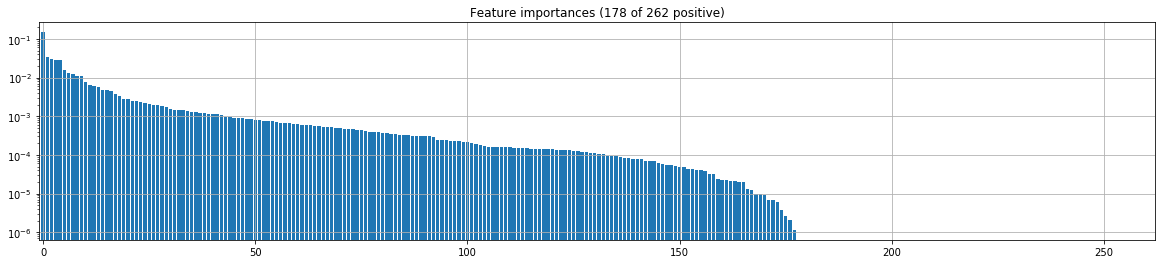

In [5]:
# Visualize the importances found
plt.rcParams['figure.figsize'] = 20,4
plt.rcParams['font.size'] = 10
plt.bar(
    x = range(len(imp)),
    height = sorted(imp, reverse = True),
    log = True
)
plt.xlim([-1, len(imp)])
posimp = len([i for i in imp if i > 0])
plt.title('Feature importances (%d of %d positive)' % (posimp, len(imp)))
plt.grid()
plt.show()

In [6]:
# Prepare the actual model: a pipeline cosisting of a custom 
# feature selector and a gradient boosted trees classifier
from sklearn.pipeline import Pipeline
from tools import scores
from sklearn.feature_selection import SelectKBest

pipe = Pipeline([
    ('selector'  , SelectKBest(scores(imp))),
    ('estimator' , GradientBoostingClassifier())
])

In [7]:
# Hyperparameter tuning by cross-validation
# (This cell is edited and run many times to tune the hyperparameters)
gs = GridSearchCV(
    estimator = pipe,
    param_grid = {
        'estimator__learning_rate'     : [.1], 
        'estimator__max_depth'         : [4], 
        'estimator__max_features'      : [16],
        'estimator__min_samples_leaf'  : [2], 
        'estimator__min_samples_split' : [16], 
        'estimator__n_estimators'      : range(120,300,5), 
        'estimator__subsample'         : [.9],
        'selector__k'                  : [180],        
    }, 
    scoring = 'neg_log_loss', 
    cv = StratifiedKFold(shuffle = True),
    n_jobs = -2, 
    verbose = 3
)
gs.fit(X, y)
clf = gs.best_estimator_
print('Best CV score', -gs.best_score_)
gs.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-2)]: Done 108 out of 108 | elapsed: 11.9min finished


Best CV score 0.320507518534


{'estimator__learning_rate': 0.1,
 'estimator__max_depth': 4,
 'estimator__max_features': 16,
 'estimator__min_samples_leaf': 2,
 'estimator__min_samples_split': 16,
 'estimator__n_estimators': 135,
 'estimator__subsample': 0.9,
 'selector__k': 180}

## Output the predictions

In [8]:
# Get the predictions ready
pred = clf.predict_proba(df[df.outcome.isnull()].drop('outcome', 1))
output = df[df.outcome.isnull()]
for i in range(3):
    output[encoder.inverse_transform(i)] = pred[:, i]
output = output.assign(train = 0).reset_index()
output = output[['submission_id', 'train', 'UE', 'FE', 'W']]

In [9]:
# Put the predictions into the required format
output = pd.read_csv('AUS_SubmissionFormat.csv').join(
    output.set_index('submission_id'),
    on = 'submission_id',
    lsuffix = '_template'
)

# Save the predictions to CSV using the first available file name
last = max(
    int(f.split('.')[0].strip('attempt')) for f in listdir() 
    if f.startswith('attempt') and f.endswith('.csv')
)
output.drop([
    c for c in output.columns if '_template' in c
], 1).to_csv('attempt%s.csv' % (str(last + 1).zfill(3)), index = False)